<a href="https://colab.research.google.com/github/ussvarma/time_series_analysis/blob/main/Company's_Expenditure_forecasting_LSTM_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement:
Title - Forecast next 12 month spend based on past spend data

You need to create a system to forecast the spend of a company based on the past historical data of the last 24 months on a monthly scale.

First you need to identify the various spends a company does, you can take an example of any base company and identify the various spends a company does in a complete year, and create some fictional spend numbers of that company as training data.

After that you need to identify various features you will consider to train your model, to predict or forecast the spending company would do in the next 12 months.

You need to think through the approach you will take, the features you will identify and the algorithm you will use to achieve this. For the ML model training you can create fictional data and perform the training.

## Importing libraries


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### reading dataset 


In [4]:
df=pd.read_csv("expenditure_200.csv")
df["Date"]= pd.to_datetime(df["Date"])
df=df[:-30]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     171 non-null    datetime64[ns]
 1   Company Id                               171 non-null    int64         
 2   Expenditure(In lakhs)                    171 non-null    float64       
 3   Profit (In lakhs)                        171 non-null    float64       
 4   Employee salary and benefits (In lakhs)  171 non-null    float64       
 5   liabilities (In lakhs)                   171 non-null    float64       
 6   R and D expenses (In lakhs)              171 non-null    float64       
 7   CSR (In lakhs)                           171 non-null    float64       
 8   Employees                                171 non-null    int64         
 9   Location                                 17

In [6]:
df.drop(columns=['Company Id'],inplace=True)

In [7]:
df=pd.get_dummies(df)

In [8]:
df.corr()

,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,Location_hyderabad,Location_mumbai
Expenditure(In lakhs),1.000000,0.811081,7.670007e-01,0.809390,7.872119e-01,0.983936,0.739419,0.571765,-1.317374e-02,2.287118e-02,-1.011603e-02
Profit (In lakhs),0.811081,1.000000,9.668494e-01,0.995998,9.766202e-01,0.802309,0.949833,0.943638,-8.923742e-05,1.070849e-02,-1.192539e-02
Employee salary and benefits (In lakhs),0.767001,0.966849,1.000000e+00,0.977454,9.600317e-01,0.757768,0.921119,0.922084,1.258935e-16,-7.737714e-17,-2.637958e-16
liabilities (In lakhs),0.809390,0.995998,9.774542e-01,1.000000,9.825044e-01,0.800235,0.947214,0.938981,-1.954438e-03,7.353445e-03,-5.950181e-03
R and D expenses (In lakhs),0.787212,0.976620,9.600317e-01,0.982504,1.000000e+00,0.779904,0.920465,0.924352,-3.278689e-03,-8.541633e-17,3.877458e-03
CSR (In lakhs),0.983936,0.802309,7.577679e-01,0.800235,7.799038e-01,1.000000,0.730853,0.568552,2.601121e-03,9.712490e-03,-1.398807e-02
Employees,0.739419,0.949833,9.211192e-01,0.947214,9.204645e-01,0.730853,1.000000,0.913824,1.179434e-02,7.258058e-03,-2.210267e-02
Taxes (In lakhs),0.571765,0.943638,9.220840e-01,0.938981,9.243519e-01,0.568552,0.913824,1.000000,7.329085e-03,2.078064e-03,-1.100225e-02
Location_bangalore,-0.013174,-0.000089,1.258935e-16,-0.001954,-3.278689e-03,0.002601,0.011794,0.007329,1.000000e+00,-6.250000e-01,-4.804413e-01
Location_hyderabad,0.022871,0.010708,-7.737714e-17,0.007353,-8.541633e-17,0.009712,0.007258,0.002078,-6.250000e-01,1.000000e+00,-3.843531e-01


In [9]:
df.tail()

,Date,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,Location_hyderabad,Location_mumbai
166,2019-10-01,91.945366,208.2360,8.1,10.293369,6.5202,0.444415,17,34.887190,1,0,0
167,2019-11-01,94.311501,209.3616,8.1,10.324048,6.5202,0.445658,17,34.515030,1,0,0
168,2019-12-01,98.919228,209.3616,8.1,10.333790,6.5202,0.447926,17,33.132712,0,1,0
169,2020-01-01,99.835793,209.3616,8.1,10.403745,6.5202,0.448354,17,32.857742,0,1,0
170,2020-02-01,111.033821,210.4872,8.1,10.438723,6.5202,0.453074,17,29.836014,0,0,1


In [10]:
df.shape

(171, 12)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     171 non-null    datetime64[ns]
 1   Expenditure(In lakhs)                    171 non-null    float64       
 2   Profit (In lakhs)                        171 non-null    float64       
 3   Employee salary and benefits (In lakhs)  171 non-null    float64       
 4   liabilities (In lakhs)                   171 non-null    float64       
 5   R and D expenses (In lakhs)              171 non-null    float64       
 6   CSR (In lakhs)                           171 non-null    float64       
 7   Employees                                171 non-null    int64         
 8   Taxes (In lakhs)                         171 non-null    float64       
 9   Location_bangalore                       17

In [12]:
df.describe()

,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,Location_hyderabad,Location_mumbai
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.00000
mean,84.188738,145.281389,6.075000,5.287539,3.527009,0.438542,14.169591,18.327795,0.438596,0.333333,0.22807
std,15.828058,39.233841,1.553104,3.147636,1.649503,0.011318,2.285610,8.391780,0.497673,0.472789,0.42082
min,49.409801,68.661600,4.050000,0.056146,1.086700,0.407423,10.000000,4.385695,0.000000,0.000000,0.00000
25%,72.966503,114.811200,4.556250,2.686318,2.173400,0.431920,12.000000,11.753115,0.000000,0.000000,0.00000
50%,90.012611,146.328000,6.075000,5.387137,3.260100,0.443357,14.000000,16.411709,0.000000,0.000000,0.00000
75%,95.579246,180.096000,7.087500,8.097419,5.433500,0.446301,16.000000,24.962855,1.000000,1.000000,0.00000
max,111.033821,210.487200,8.100000,10.438723,6.520200,0.453074,18.000000,34.887190,1.000000,1.000000,1.00000


In [13]:
df.isnull().sum()

Date                                       0
Expenditure(In lakhs)                      0
Profit (In lakhs)                          0
Employee salary and benefits (In lakhs)    0
liabilities (In lakhs)                     0
R and D expenses (In lakhs)                0
CSR (In lakhs)                             0
Employees                                  0
Taxes (In lakhs)                           0
Location_bangalore                         0
Location_hyderabad                         0
Location_mumbai                            0
dtype: int64

## Data visualization


#### Correlation map



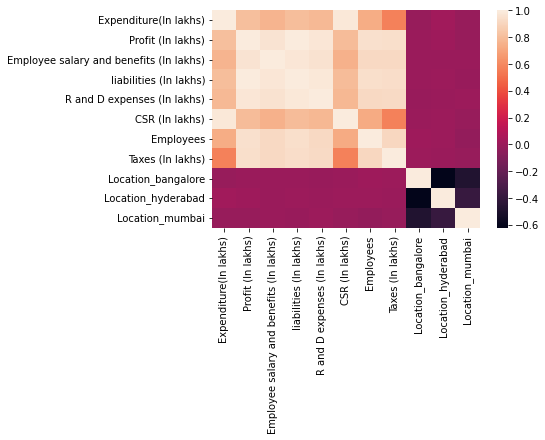

In [14]:
sns.heatmap(df.corr())

In [15]:
df.corr()

,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,Location_hyderabad,Location_mumbai
Expenditure(In lakhs),1.000000,0.811081,7.670007e-01,0.809390,7.872119e-01,0.983936,0.739419,0.571765,-1.317374e-02,2.287118e-02,-1.011603e-02
Profit (In lakhs),0.811081,1.000000,9.668494e-01,0.995998,9.766202e-01,0.802309,0.949833,0.943638,-8.923742e-05,1.070849e-02,-1.192539e-02
Employee salary and benefits (In lakhs),0.767001,0.966849,1.000000e+00,0.977454,9.600317e-01,0.757768,0.921119,0.922084,1.258935e-16,-7.737714e-17,-2.637958e-16
liabilities (In lakhs),0.809390,0.995998,9.774542e-01,1.000000,9.825044e-01,0.800235,0.947214,0.938981,-1.954438e-03,7.353445e-03,-5.950181e-03
R and D expenses (In lakhs),0.787212,0.976620,9.600317e-01,0.982504,1.000000e+00,0.779904,0.920465,0.924352,-3.278689e-03,-8.541633e-17,3.877458e-03
CSR (In lakhs),0.983936,0.802309,7.577679e-01,0.800235,7.799038e-01,1.000000,0.730853,0.568552,2.601121e-03,9.712490e-03,-1.398807e-02
Employees,0.739419,0.949833,9.211192e-01,0.947214,9.204645e-01,0.730853,1.000000,0.913824,1.179434e-02,7.258058e-03,-2.210267e-02
Taxes (In lakhs),0.571765,0.943638,9.220840e-01,0.938981,9.243519e-01,0.568552,0.913824,1.000000,7.329085e-03,2.078064e-03,-1.100225e-02
Location_bangalore,-0.013174,-0.000089,1.258935e-16,-0.001954,-3.278689e-03,0.002601,0.011794,0.007329,1.000000e+00,-6.250000e-01,-4.804413e-01
Location_hyderabad,0.022871,0.010708,-7.737714e-17,0.007353,-8.541633e-17,0.009712,0.007258,0.002078,-6.250000e-01,1.000000e+00,-3.843531e-01


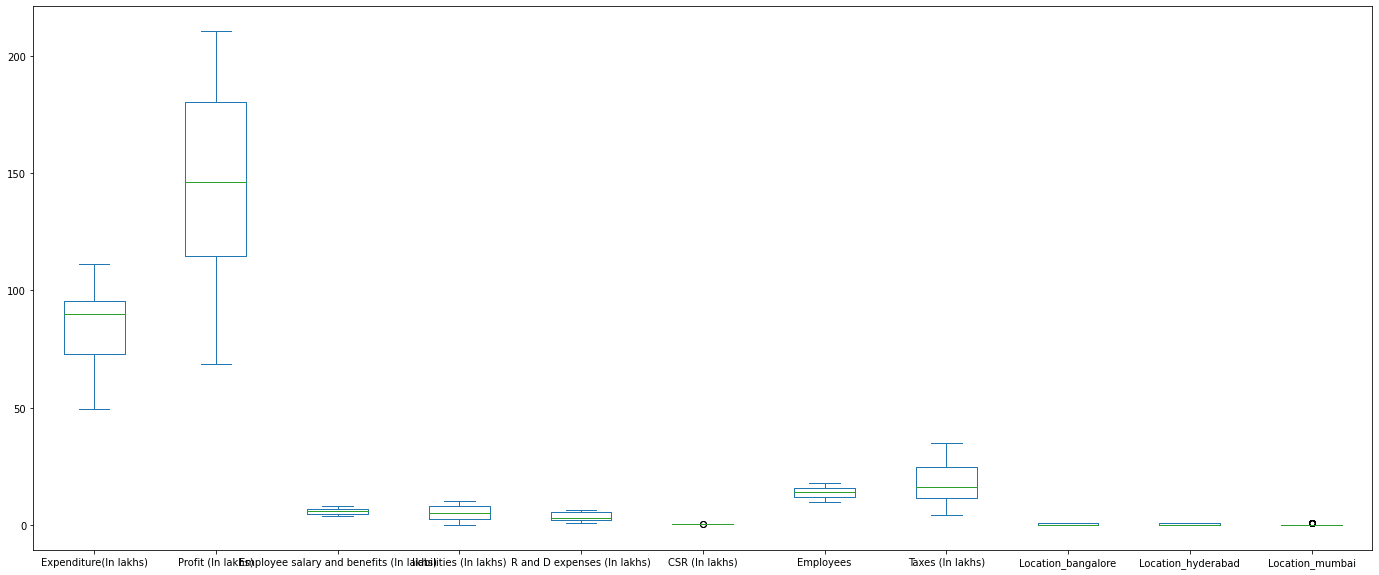

In [16]:
df.plot(kind='box',figsize=(24,10))
plt.show()

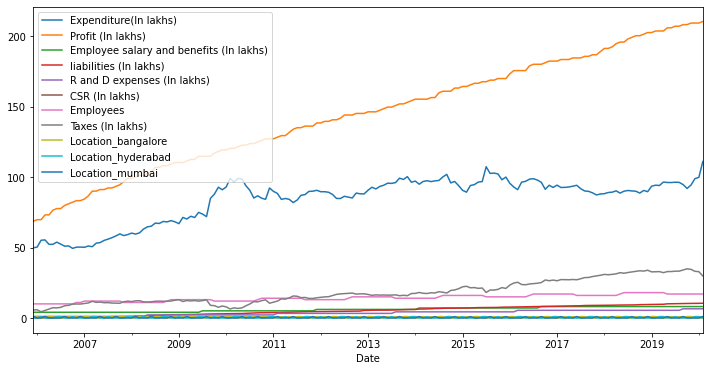

In [17]:
df.plot(x="Date",figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcea7cb5f10>,
      dtype=object)

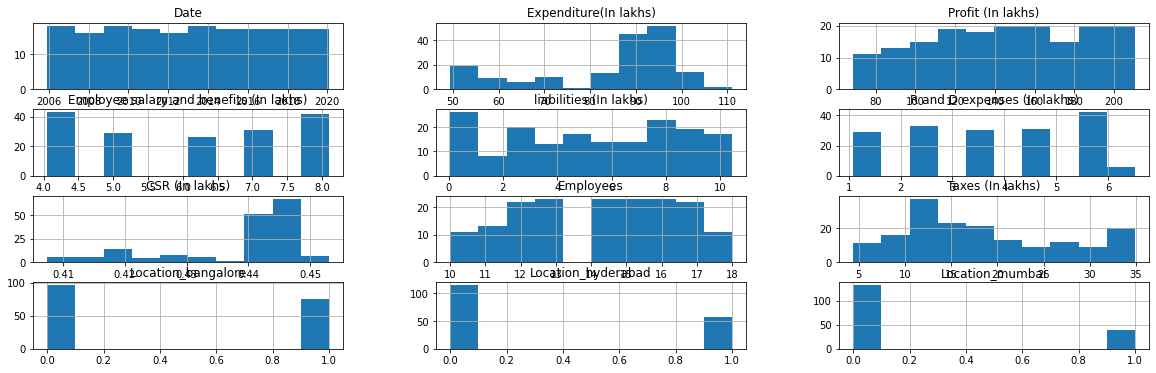

In [18]:
df.hist(figsize=(20,6))

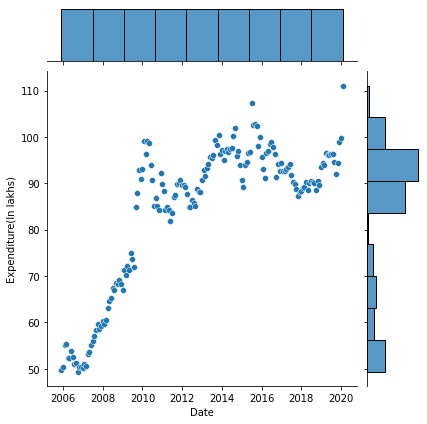

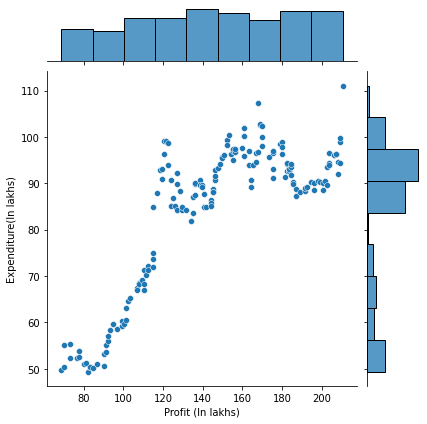

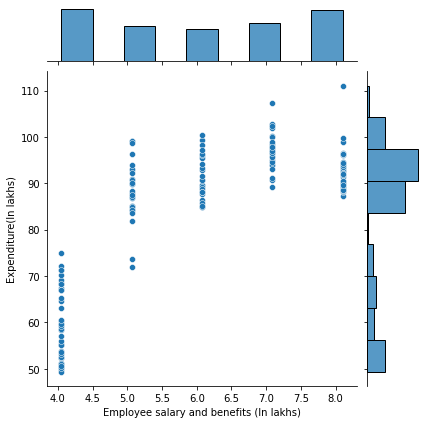

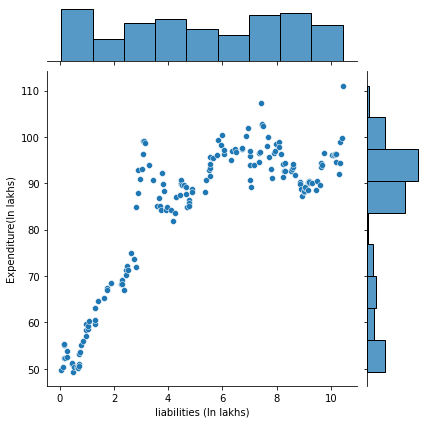

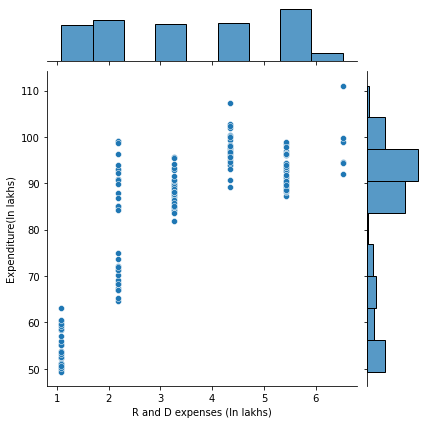

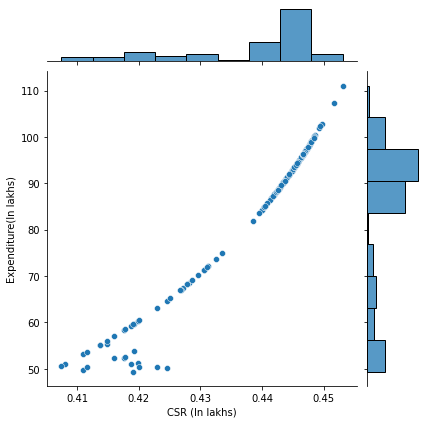

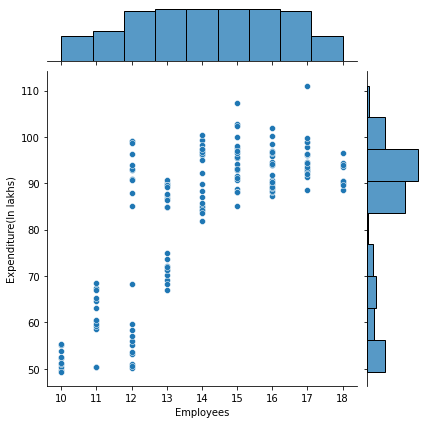

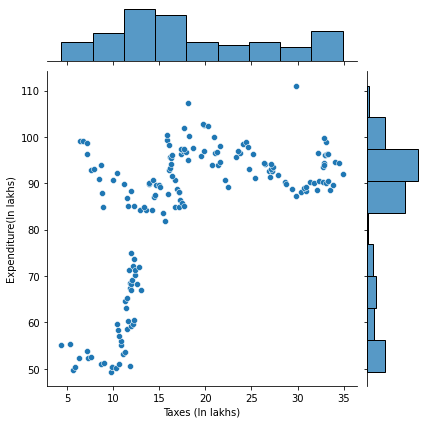

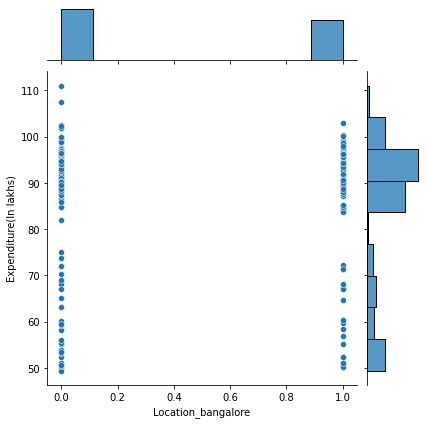

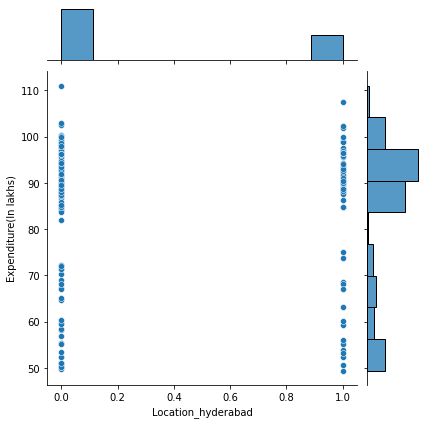

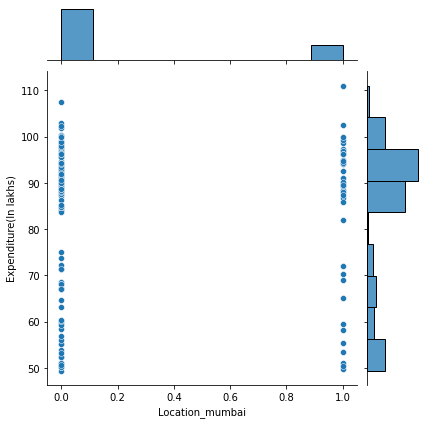

In [19]:
for col in df.columns:
  if col != "Expenditure(In lakhs)":
    sns.jointplot(x = col, y ='Expenditure(In lakhs)', data = df)


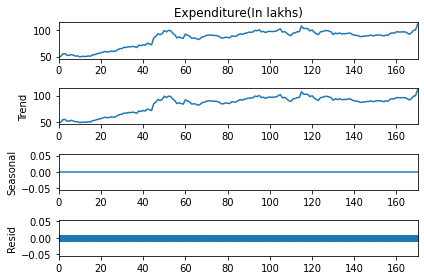

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Expenditure(In lakhs)'], 
                            model ='additive',period=1)
# ETS plot 
result.plot();

#### As we are using LSTM , we dont need to check for stationarity of the data.

In [21]:
df.index=df['Date']
df.index = pd.to_datetime(df.index)

In [22]:
df.drop(columns=["Date"],inplace=True)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2005-12-01 to 2020-02-01
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Expenditure(In lakhs)                    171 non-null    float64
 1   Profit (In lakhs)                        171 non-null    float64
 2   Employee salary and benefits (In lakhs)  171 non-null    float64
 3   liabilities (In lakhs)                   171 non-null    float64
 4   R and D expenses (In lakhs)              171 non-null    float64
 5   CSR (In lakhs)                           171 non-null    float64
 6   Employees                                171 non-null    int64  
 7   Taxes (In lakhs)                         171 non-null    float64
 8   Location_bangalore                       171 non-null    uint8  
 9   Location_hyderabad                       171 non-null    uint8  
 10  Location_mumbai                

### train and test split


In [24]:
test_split=round(len(df)*0.30)
print(test_split)

51


In [25]:
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(120, 11)
(51, 11)


In [26]:
df_for_training

,Expenditure(In lakhs),Profit (In lakhs),Employee salary and benefits (In lakhs),liabilities (In lakhs),R and D expenses (In lakhs),CSR (In lakhs),Employees,Taxes (In lakhs),Location_bangalore,Location_hyderabad,Location_mumbai
Date,,,,,,,,,,,
2005-12-01,49.813290,68.6616,4.0500,0.056146,1.0867,0.411013,10,5.654493,0,0,1
2006-01-01,50.316402,69.7872,4.0500,0.125139,1.0867,0.411572,10,5.841239,1,0,0
2006-02-01,55.168217,69.7872,4.0500,0.146133,1.0867,0.413629,10,4.385695,0,1,0
2006-03-01,55.412300,73.1640,4.0500,0.150954,1.0867,0.414765,10,5.325510,0,0,1
2006-04-01,52.284027,73.1640,4.0500,0.156165,1.0867,0.416054,10,6.263992,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,107.372543,167.7144,7.0875,7.414776,4.3468,0.451629,15,18.102557,0,1,0
2015-08-01,102.610390,168.8400,7.0875,7.474060,4.3468,0.449610,15,19.868883,0,0,1
2015-09-01,102.849495,168.8400,7.0875,7.478098,4.3468,0.449716,15,19.797151,1,0,0


### Creating trainx,trainy,testx,testy



In [27]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)-12):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i:i+12,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training.values,24)
testX,testY=createXY(df_for_testing.values,24)

In [28]:
print(trainX.shape,testX.shape)

(84, 24, 11) (15, 24, 11)


In [29]:
print(trainX)

[[[ 49.81329   68.6616     4.05     ...   0.         0.         1.      ]
  [ 50.316402  69.7872     4.05     ...   1.         0.         0.      ]
  [ 55.168217  69.7872     4.05     ...   0.         1.         0.      ]
  ...
  [ 58.256641  93.4248     4.05     ...   0.         0.         1.      ]
  [ 59.681301  94.5504     4.05     ...   1.         0.         0.      ]
  [ 58.480801  96.8016     4.05     ...   1.         0.         0.      ]]

 [[ 50.316402  69.7872     4.05     ...   1.         0.         0.      ]
  [ 55.168217  69.7872     4.05     ...   0.         1.         0.      ]
  [ 55.4123    73.164      4.05     ...   0.         0.         1.      ]
  ...
  [ 59.681301  94.5504     4.05     ...   1.         0.         0.      ]
  [ 58.480801  96.8016     4.05     ...   1.         0.         0.      ]
  [ 59.198112  99.0528     4.05     ...   0.         1.         0.      ]]

 [[ 55.168217  69.7872     4.05     ...   0.         1.         0.      ]
  [ 55.4123    73.164 

In [30]:
print(trainY)

[[ 59.198112  60.24419   59.556767 ...  68.518173  68.204353  69.10099 ]
 [ 60.24419   59.556767  60.423519 ...  68.204353  69.10099   68.244202]
 [ 59.556767  60.423519  63.113434 ...  69.10099   68.244202  66.968987]
 ...
 [101.942894  95.890579  96.906769 ...  96.827065 107.372543 102.61039 ]
 [ 95.890579  96.906769  93.992691 ... 107.372543 102.61039  102.849495]
 [ 96.906769  93.992691  90.630295 ... 102.61039  102.849495 102.246758]]


### For feature scaling


In [31]:
# converting into 2D
nsamples, nx, ny = trainX.shape
trainX = trainX.reshape((nsamples,nx*ny))
testX=testX.reshape((testX.shape[0],nx*ny))

In [32]:
print(trainX.shape,testX.shape)

(84, 264) (15, 264)


In [33]:
# feature scaling for x-variables
scaler_x = StandardScaler()
trainX = scaler_x.fit_transform(trainX)
testX=scaler_x.transform(testX)

In [34]:
# feature scaling for y-variable
scaler_y = StandardScaler()
trainY = scaler_y.fit_transform(trainY)
testY = scaler_y.transform(testY)

In [35]:
print(trainX.shape)

(84, 264)


In [36]:
# reshaping back to original form
trainX = trainX.reshape((-1,24,11))
testX = testX.reshape((-1,24,11))

In [37]:
print("trainX Shape-- ",trainX.shape)
print("testX Shape-- ",testX.shape)

trainX Shape--  (84, 24, 11)
testX Shape--  (15, 24, 11)


In [38]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[-1.47562362 -1.96989462 -0.87618268 -1.55309873 -1.18321596 -1.67104754
  -1.6851507  -1.89671594 -0.8872621  -0.70710678  1.84960878]
 [-1.48484663 -1.97933498 -0.89469342 -1.54184776 -1.21052363 -1.67546779
  -1.71715039 -1.88445207  1.12706267 -0.70710678 -0.54065487]
 [-1.21554693 -2.0410595  -0.91378545 -1.56153204 -1.23884496 -1.55078894
  -1.75216522 -2.41536118 -0.8872621   1.41421356 -0.54065487]
 [-1.22954331 -1.94799464 -0.9334555  -1.59160117 -1.26824762 -1.49669478
  -1.79030042 -2.20569945 -0.90889326 -0.6882472   1.84960878]
 [-1.46062123 -2.00881067 -0.95370727 -1.62319333 -1.2988078  -1.42648921
  -1.83171319 -1.96636452  1.10023921 -0.70710678 -0.52223297]
 [-1.49980772 -1.9099252  -0.97455053 -1.64785525 -1.33061126 -1.33227465
  -1.87661547 -1.67946449  1.12706267 -0.72613547 -0.52223297]
 [-1.43853086 -1.91188599 -0.99600045 -1.64003739 -1.36375447 -1.22202943
  -1.92527938 -1.77168358 -0.8660254   1.37715349 -0.54065487]
 [-1.56681799 -1.96824955 -

In [39]:
print("testX[0]-- \n",testX[0])
print("testY[0]-- ",testY[0])

testX[0]-- 
 [[ 1.68389306  2.68689191  3.28981799  3.3078451   2.68912717  1.45231929
   2.05962864  3.09748747 -0.8872621  -0.70710678  1.84960878]
 [ 1.3910785   2.82779913  3.20462916  3.29185171  2.65089352  1.26044816
   2.00039169  3.81882887  1.12706267 -0.70710678 -0.54065487]
 [ 1.20077571  2.91777305  3.12610813  3.27764751  2.61533937  1.12554286
   1.94587193  4.28022711  1.12706267 -0.70710678 -0.54065487]
 [ 1.05168638  2.90864953  3.05350698  3.24137197  3.86586322  1.01433589
   1.89561221  4.53084916 -0.90889326  1.45296631 -0.54065487]
 [ 1.36983521  2.89548469  2.98619819  3.24197753  3.83530304  1.23253022
   1.84924155  4.01119991 -0.90889326  1.41421356 -0.52223297]
 [ 1.38051457  2.88401948  2.9236516   3.22553679  3.80830118  1.23246842
   1.80646162  3.96030962 -0.8872621  -0.72613547  1.91485422]
 [ 1.45653719  3.02960396  2.86541669  3.20331195  3.78480173  1.27345644
   2.50550056  4.1327777   1.15470054 -0.72613547 -0.54065487]
 [ 1.45087015  3.06530668  2

In [40]:
print("testX_shape:\n",testX.shape)
print("testY_shape:-- ",testY.shape)

testX_shape:
 (15, 24, 11)
testY_shape:--  (15, 12)


### Model building using hyper parameter tuning


In [41]:
def build_model(layers,neurons,loss):
    grid_model = Sequential()
    grid_model.add(LSTM(neurons,return_sequences=True,input_shape=(24,11)))
    for i in range(layers):
        if i == layers-1:
            grid_model.add(LSTM(neurons))
        else:
            grid_model.add(LSTM(neurons, return_sequences=True))
            grid_model.add(Dropout(0.2))
#     grid_model.add(LSTM(50))
     
    grid_model.add(Dense(12))

    grid_model.compile(loss = loss,optimizer = "adam")
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,validation_data=(testX,testY))
parameters = {'batch_size' : [16,32],
              'epochs' : [100,200],
             "layers":[2,3,4],
             "neurons":[50,100,150],
              "loss": ["mse","mape"]
              }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)


In [42]:
# hyper parameter tuning
callback = EarlyStopping(monitor='val_loss', patience=3)
grid_search = grid_search.fit(trainX,trainY,callbacks=[callback])

Epoch 1/100
3/3 [==============================] - 10s 489ms/step - loss: 0.5538 - val_loss: 0.1412
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.3142 - val_loss: 0.1104
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1708 - val_loss: 0.2713
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1712 - val_loss: 0.3223
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 1.1715
Epoch 1/100
3/3 [==============================] - 5s 503ms/step - loss: 1.3604 - val_loss: 0.3055
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 1.2176 - val_loss: 0.2724
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 1.1058 - val_loss: 0.2463
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 0.9882 - val_loss: 0.2376
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8978 - val_loss: 0.2407
Epoch 6/100
3/3 [====================

In [43]:
my_model=grid_search.best_estimator_.model
my_model.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_576 (LSTM)             (None, 24, 150)           97200     
                                                                 
 lstm_577 (LSTM)             (None, 24, 150)           180600    
                                                                 
 dropout_288 (Dropout)       (None, 24, 150)           0         
                                                                 
 lstm_578 (LSTM)             (None, 150)               180600    
                                                                 
 dense_144 (Dense)           (None, 12)                1812      
                                                                 
Total params: 460,212
Trainable params: 460,212
Non-trainable params: 0
_________________________________________________________________


In [44]:
grid_search.best_params_

{'batch_size': 32, 'epochs': 200, 'layers': 2, 'loss': 'mse', 'neurons': 150}

### predictions on testX dataset



In [45]:
prediction=my_model.predict(testX)


In [46]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[1.0878755  1.0569646  1.0808117  0.8314333  0.8818938  0.8540866
  0.9350586  0.9326631  1.2885927  0.92342037 1.0758154  1.0199356 ]
 [1.0883301  1.0580472  1.0830745  0.8298361  0.88357264 0.85566306
  0.93743265 0.9329576  1.2929512  0.92667264 1.077273   1.020475  ]
 [1.0901206  1.0606068  1.085478   0.827694   0.8840794  0.85717535
  0.940237   0.932808   1.2964954  0.9295087  1.0808798  1.0222447 ]
 [1.0903461  1.0614717  1.087133   0.8259549  0.8851262  0.8589672
  0.9413391  0.9324213  1.2987354  0.93133104 1.0830809  1.0223306 ]
 [1.0897429  1.0621736  1.0861317  0.8232563  0.88583386 0.85937023
  0.94263256 0.9328947  1.3001525  0.9341487  1.0864323  1.0254331 ]
 [1.0890045  1.062496   1.0862144  0.8204971  0.88701165 0.8607019
  0.94344765 0.9332991  1.3032441  0.93559766 1.088363   1.026922  ]
 [1.0894222  1.063898   1.0862187  0.8177251  0.88694084 0.86261237
  0.9450368  0.9338974  1.3060943  0.93616885 1.0909318  1.0282626 ]
 [1.0913063  1.0662073  1.087593

In [47]:
# inverse transforming to get back to original values
testY=scaler_y.inverse_transform(testY)
prediction=scaler_y.inverse_transform(prediction)

In [48]:
print("Pred Values-- " ,prediction)
print("\nOriginal Values-- ",testY)

Pred Values--  [[ 98.19636   97.90305   98.16205   95.446236  96.05584   95.881516
   96.81009   96.90585  100.650986  97.500465  99.127815  98.82432 ]
 [ 98.20167   97.91533   98.18693   95.429306  96.07302   95.897156
   96.833     96.908615 100.69161   97.53018   99.1409    98.82905 ]
 [ 98.22256   97.94436   98.21335   95.4066    96.07821   95.91216
   96.86006   96.90721  100.724655  97.5561    99.17327   98.844574]
 [ 98.22519   97.95417   98.23155   95.38816   96.08891   95.92994
   96.8707    96.90359  100.74553   97.572754  99.19303   98.84533 ]
 [ 98.21815   97.96213   98.22054   95.35956   96.09616   95.93394
   96.88318   96.90803  100.75874   97.598495  99.223114  98.87254 ]
 [ 98.20953   97.96578   98.22145   95.33031   96.10821   95.94715
   96.891045  96.91182  100.78756   97.61174   99.24045   98.885605]
 [ 98.21441   97.98168   98.2215    95.30092   96.10748   95.9661
   96.90639   96.91743  100.81413   97.61696   99.263504  98.89737 ]
 [ 98.23639   98.00787   98.2366

### Different plots comparing testY and predictions


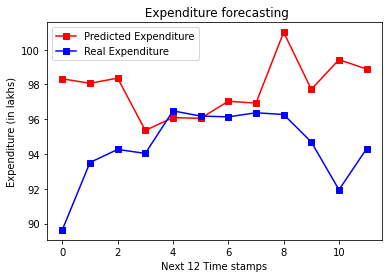

In [67]:
#plt.xlim([100,500])
plt.plot(prediction[12], color = 'red', label = 'Predicted Expenditure',marker="s")
plt.plot(testY[12], color = 'blue', label = 'Real Expenditure',marker="s")
plt.title(' Expenditure forecasting')
plt.xlabel('Next 12 Time stamps')
plt.ylabel('Expenditure (in lakhs)')
plt.legend()
plt.show()

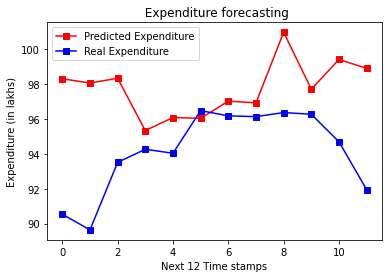

In [68]:
#plt.xlim([100,500])
plt.plot(prediction[11], color = 'red', label = 'Predicted Expenditure',marker="s")
plt.plot(testY[11], color = 'blue', label = 'Real Expenditure',marker="s")
plt.title(' Expenditure forecasting')
plt.xlabel('Next 12 Time stamps')
plt.ylabel('Expenditure (in lakhs)')
plt.legend()
plt.show()

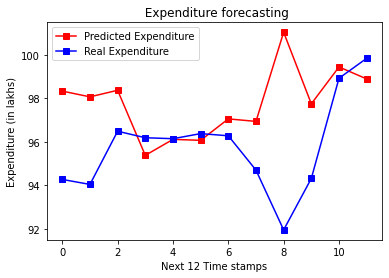

In [51]:
#plt.xlim([100,500])
plt.plot(prediction[14], color = 'red', label = 'Predicted Expenditure',marker="s")
plt.plot(testY[14], color = 'blue', label = 'Real Expenditure',marker="s")
plt.title(' Expenditure forecasting')
plt.xlabel('Next 12 Time stamps')
plt.ylabel('Expenditure (in lakhs)')
plt.legend()
plt.show()

In [52]:
print(testX[0])

[[ 1.68389306  2.68689191  3.28981799  3.3078451   2.68912717  1.45231929
   2.05962864  3.09748747 -0.8872621  -0.70710678  1.84960878]
 [ 1.3910785   2.82779913  3.20462916  3.29185171  2.65089352  1.26044816
   2.00039169  3.81882887  1.12706267 -0.70710678 -0.54065487]
 [ 1.20077571  2.91777305  3.12610813  3.27764751  2.61533937  1.12554286
   1.94587193  4.28022711  1.12706267 -0.70710678 -0.54065487]
 [ 1.05168638  2.90864953  3.05350698  3.24137197  3.86586322  1.01433589
   1.89561221  4.53084916 -0.90889326  1.45296631 -0.54065487]
 [ 1.36983521  2.89548469  2.98619819  3.24197753  3.83530304  1.23253022
   1.84924155  4.01119991 -0.90889326  1.41421356 -0.52223297]
 [ 1.38051457  2.88401948  2.9236516   3.22553679  3.80830118  1.23246842
   1.80646162  3.96030962 -0.8872621  -0.72613547  1.91485422]
 [ 1.45653719  3.02960396  2.86541669  3.20331195  3.78480173  1.27345644
   2.50550056  4.1327777   1.15470054 -0.72613547 -0.54065487]
 [ 1.45087015  3.06530668  2.81110868  3.

In [53]:
from sklearn.metrics import mean_squared_error
#from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
mean_squared_error(prediction[0], testY[0])

69.60016614395396